<a href="https://www.kaggle.com/code/kenny3s/iht-rehalf?scriptVersionId=165565186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import shutil
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
from skimage import img_as_ubyte, io
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D#画3d图案所必需的

In [2]:
data_dir = '/kaggle/input/celeb-m/Celebrity Faces Dataset'

In [3]:
def block_no_expand(name):
    im=np.array(Image.open(name))
    im_lab=cv2.cvtColor(im,cv2.COLOR_RGB2HSV)
    im_lab[:,:,-1]=np.interp(im_lab[:,:,-1],(0,255),(0,255/4))
    im_rgb=cv2.cvtColor(im_lab,cv2.COLOR_HSV2RGB)
    im_ht=Image.fromarray(im_rgb).convert("1")
    im_ht=img_as_ubyte(im_ht)
    # gray_level(im_ht,(2,4),True)
    return im_ht

def find_best_params(gt_path):
    img = block_no_expand(gt_path)
    pil_halftone = Image.fromarray(img).convert('L').convert("1")
    halftone = img_as_ubyte(pil_halftone)
    ref = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    def IHT(radius=3, sigma_s=100, cnts=3):
        dehalftoned = halftone.copy()
        for i in range(cnts):
            dehalftoned = cv2.bilateralFilter(dehalftoned, radius, sigma_s, sigma_s)
        return dehalftoned

    best_psnr = 0
    best_params = None
    x = []
    y = []
    z = []
    for radius in range(3, 50, 2):
        for sigma_s in [300]:
            for cnts in range(1, 15, 1):
                I = cv2.GaussianBlur(halftone.copy(), (radius, radius), 0)
                dehalftoned = IHT(radius, sigma_s, cnts)
                ehist = cv2.equalizeHist(dehalftoned)
                psnr = peak_signal_noise_ratio(ehist, ref)
                x.append(radius)
                y.append(cnts)
                z.append(round(psnr, 4))
                if psnr > best_psnr:
                    best_psnr = psnr
                    best_params = (radius, sigma_s, cnts)
    return best_params, best_psnr,x,y,z

In [4]:
best_params, best_psnr,x,y,z = find_best_params(f'/kaggle/input/celeb-m/Celebrity Faces Dataset/0000.jpg')
print(f"Best_params:{best_params}, Best_PSNR:{best_psnr}")

Best_params:(7, 300, 2), Best_PSNR:20.708504047088123


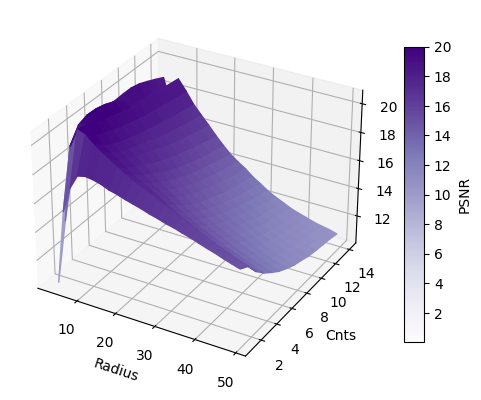

In [5]:
x_mesh, y_mesh = np.meshgrid(np.linspace(min(x), max(x), len(np.unique(x))), 
                             np.linspace(min(y), max(y), len(np.unique(y))), 
                             indexing='ij')

z_mesh = griddata((x, y), z, (x_mesh, y_mesh), method='cubic')

colors_ref = np.zeros(z_mesh.shape)
for i in range(z_mesh.shape[0]):
    for j in range(z_mesh.shape[1]):
        colors_ref[i,j] = z_mesh[i,j]

colors_norm = colors_ref / np.max(colors_ref)

fig = plt.figure()
sub = fig.add_subplot(111, projection='3d')
colors = z_mesh / np.max(z_mesh)
surf = sub.plot_surface(x_mesh, y_mesh, z_mesh, cmap=plt.cm.Purples, facecolors=plt.cm.Purples(colors))

cb = fig.colorbar(surf, shrink=0.8, aspect=15, label='PSNR')
cb.set_ticks([i for i in np.arange(0.1,1.1,0.1)])
cb.ax.set_yticklabels([str(int(i*20)) for i in np.arange(0.1,1.1,0.1)])

sub.set_xlabel('Radius')
sub.set_ylabel('Cnts')

plt.show()

In [6]:
# with open('best_params.txt', 'w') as f:
#     f.write('id, cnts, radius, sigma_s\n')
#     for img in tqdm(os.listdir(data_dir)):
#         best_params, best_psnr= find_best_params(f'{data_dir}/{img}')
#         print(f"best_params:{best_params}---best_psnr:{best_psnr}")
#         f.write(f'{img[:-4]}, {best_params[0]}, {best_params[1]}, {best_params[2]}\n')